In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [10]:
# 2. Đọc file CSV và thiết lập chỉ số là giá 'Close'
df = pd.read_csv('/content/drive/MyDrive/Final/VCB_Stock_Data.csv')
df1 = df.reset_index()['Close']
df1 = df1[~np.isnan(df1)]
df1

0       12181.833984
8       11925.374023
9       11882.630859
10      12096.347656
11      12096.347656
            ...     
2554    85200.000000
2555    85000.000000
2556    84200.000000
2557    84200.000000
2558    83700.000000
Name: Close, Length: 2459, dtype: float64

In [11]:
# 3. Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [12]:
# 4. Chia dữ liệu thành tập huấn luyện và tập kiểm thử ti lệ 80% và 20%
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [13]:
# 5. Tạo hàm tạo dataset
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [14]:
# 6. Reshape dữ liệu cho việc huấn luyện
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)


In [15]:
 # 7. Reshape input to be [samples, time steps, features] which is required for RNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [16]:
# 8. Định nghĩa mô hình RNN
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [17]:
# 9. Huấn luyện mô hình với dữ liệu huấn luyện
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
30/30 [==============================] - 5s 49ms/step - loss: 0.0399
Epoch 2/100
30/30 [==============================] - 1s 45ms/step - loss: 0.0012
Epoch 3/100
30/30 [==============================] - 2s 56ms/step - loss: 3.9169e-04
Epoch 4/100
30/30 [==============================] - 2s 51ms/step - loss: 3.0554e-04
Epoch 5/100
30/30 [==============================] - 1s 24ms/step - loss: 2.8124e-04
Epoch 6/100
30/30 [==============================] - 1s 20ms/step - loss: 2.5712e-04
Epoch 7/100
30/30 [==============================] - 1s 20ms/step - loss: 2.6841e-04
Epoch 8/100
30/30 [==============================] - 1s 20ms/step - loss: 2.5296e-04
Epoch 9/100
30/30 [==============================] - 1s 20ms/step - loss: 2.2443e-04
Epoch 10/100
30/30 [==============================] - 1s 20ms/step - loss: 2.2047e-04
Epoch 11/100
30/30 [==============================] - 1s 28ms/step - loss: 2.3017e-04
Epoch 12/100
30/30 [==============================] - 1s 32ms/step - lo

In [18]:
# 10. Dự đoán dữ liệu kiểm thử
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

13/13 [==============================] - 0s 7ms/step


In [19]:
# 11. Đảo ngược chuẩn hóa cho dữ liệu dự đoán
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [20]:
# 12. Đánh giá độ chính xác của thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_log_error
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_log_error
# MAPE
test_mape = mean_absolute_percentage_error(ytest,y_pred)
print('Testing MAPE:', test_mape)
# MSLE
test_msle = mean_squared_log_error(ytest,y_pred)
print('Testing MSLE:', test_msle)

Testing RMSE: 75354.98892376723
Testing MAPE: 96018.0860041697
Testing MSLE: 113.16735135856536


In [21]:
# 13. Dự đoán cho 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
while(i < 30):

    if(len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        i = i + 1

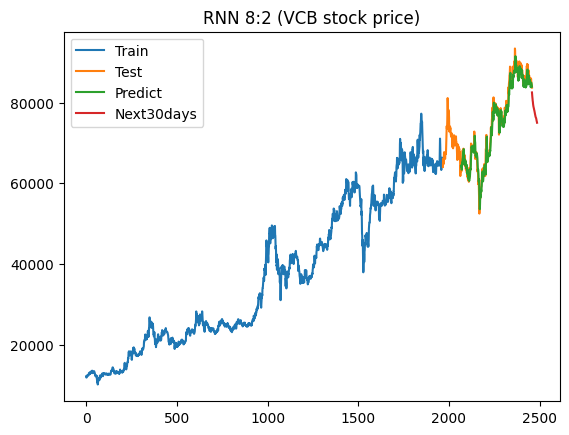

In [22]:
# 14. Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)
predict_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+28, step=1)  # Giả sử chiều dài là 29
plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
plt.legend(['Train', 'Test', 'Predict', 'Next30days'])
plt.title('RNN 8:2 (VCB stock price)')
plt.show()
